In [3]:
#export
import pandas as pd
import numpy as np

In [4]:
DATA_LOC = '../data/'

## Standard for næringsgruppering (SN)
kilde: https://www.ssb.no/klass/klassifikasjoner/6

In [3]:
nace_2007 = pd.read_csv(DATA_LOC + '30.csv', sep=';', encoding='iso-8859-1') 
nace_2007.head(1)

,code,parentCode,level,name,shortName,notes,validFrom,validTo
0,01,A,2,"Jordbruk og tjenester tilknyttet jordbruk, jak...","Jordbruk, tilhør. tjenester, jakt",Inkluderer: Denne næringen omfatter to basisak...,NaN,NaN


## NACE (næringsgruppe) koder pr foretak

In [5]:
nace = pd.read_csv(DATA_LOC + 'EnhetNacekode.tab', sep='\t', encoding='utf-8', dtype={'nacekode': object}) 
nace_pivot = pd.pivot_table(nace.sort_values(by=['orgnr', 'rekkefolge']),
                            index='orgnr', columns='rekkefolge',
                            values='nacekode', aggfunc='first').reset_index()
nace_pivot.columns=['orgnr', 'nace_1', 'nace_2', 'nace_3','nace_4']
nace_pivot.head(1)

,orgnr,nace_1,nace_2,nace_3,nace_4
0,810033622,68.209,None,None,None


In [6]:
len(nace_pivot)

1070788

In [7]:
enhet = pd.read_csv(DATA_LOC + 'EnhetNavnOrgform.tab', sep='\t', encoding='iso-8859-1') 
enhet.head()

,orgnr,orgform,navn
0,810033622,AS,WILTHIL & CO AS
1,810034882,AS,SANDNES ELEKTRISKE FORRETNING AS
2,810059672,AS,AASEN & FARSTAD AS
3,810093382,AS,BRIS EIENDOM AS
4,810094532,AS,AGDERPOSTEN MEDIER AS


In [8]:
len(enhet)

1124902

## Beskrivelser for NACE kodene

In [9]:
nace_beskrivelse = pd.read_csv(DATA_LOC + 'nace_beskrivelse.tab', sep='\t', encoding='utf-8', dtype={'nacekode': object}) 
nace_beskrivelse.drop(['beskrivelse2'], axis=1, inplace=True)
nace_beskrivelse.columns = ['nace', 'tekst']

FileNotFoundError: File b'../data/nace_beskrivelse.tab' does not exist

In [9]:
nace_beskrivelse.head()

,nace,tekst
0,00.000,Uoppgitt
1,01.110,"Dyrking av korn (unntatt ris), belgvekster og ..."
2,01.120,Dyrking av ris
3,01.130,"Dyrking av grønnsaker, meloner, rot- og knollv..."
4,01.140,Dyrking av sukkerrør


In [10]:
nace_beskrivelse.to_json(DATA_LOC + 'nace_beskrivelse.json', orient="records")

## Formålet med virksomheten beskrevet i tekst

In [10]:
formål = pd.read_csv(DATA_LOC + 'EnhetOrgformVirksomhetArtBransje.tab', sep='\t', encoding='iso-8859-1') 
formål.columns = ['orgnr', 'orgform', 'linje_nr', 'linje_tekst']

In [11]:
len(formål)

1901937

In [12]:
formål.head(5)

,orgnr,orgform,linje_nr,linje_tekst
0,810033622,AS,1,"Handel, engros og detalj og agenturer, herunder"
1,810033622,AS,2,import av varer.
2,810034882,AS,10,"Handel og innstallasjonsvirksomhet, eller anne..."
3,810034882,AS,20,"med dette, samt delta I annen virksomhet."
4,810059672,AS,10,Utleie av forretningseiendommer.


In [13]:
# eksempel: før sammenslåing
list(formål[formål['orgnr'] == 810034882]['linje_tekst'])

['Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet',
 'med dette, samt delta I annen virksomhet.']

In [14]:
# eksempel: etter sammenslåing
formål_t = formål[['orgnr','linje_tekst']].groupby('orgnr')['linje_tekst'].apply(lambda x: ' '.join(x)).reset_index()

In [16]:
list(formål_t[formål_t['orgnr'] == 810034882]['linje_tekst'])

['Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet med dette, samt delta I annen virksomhet.']

In [17]:
len(formål_t)

1102419

In [18]:
formål_t.head()

,orgnr,linje_tekst
0,810033622,"Handel, engros og detalj og agenturer, herunde..."
1,810034882,"Handel og innstallasjonsvirksomhet, eller anne..."
2,810059672,Utleie av forretningseiendommer.
3,810093382,"Eie og drift av fast eiendom, investering i ak..."
4,810094532,Utgi avisen Agderposten og drive annen virksom...


In [19]:
df = pd.merge(formål_t, nace_pivot, on='orgnr', how='inner') 

In [20]:
len(df)

1049701

## Datasett for maskinlæring

In [47]:
import spacy
import re

#load language model from norsk_spacy
nlp = spacy.load('nb_ud_ner')

def tokenize(x):
    tokens = nlp.tokenizer(x)
    return [t.text.lower() for t in tokens if not t.is_punct]

In [48]:
# test
tokenize('Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet med dette, samt delta I annen virksomhet.')

['handel',
 'og',
 'innstallasjonsvirksomhet',
 'eller',
 'annen',
 'virksomhet',
 'forbundet',
 'med',
 'dette',
 'samt',
 'delta',
 'i',
 'annen',
 'virksomhet']

In [61]:
#export
def get_dataset(row):
    s = row['linje_tekst']
    tokens = tokenize(s)
    tokens.append(f"__label__{row['nace_1']}")
    linje = ' '.join(tokens)
    return linje

In [62]:
dataset = df.apply(get_dataset, axis=1)

In [63]:
dataset.head(5)

0    handel engros og detalj og agenturer herunder ...
1    handel og innstallasjonsvirksomhet eller annen...
2      utleie av forretningseiendommer __label__68.209
3    eie og drift av fast eiendom investering i aks...
4    utgi avisen agderposten og drive annen virksom...
dtype: object

In [64]:
len(dataset)

1049701

In [65]:
dataset.iloc[0]

'handel engros og detalj og agenturer herunder import av varer __label__68.209'

In [60]:
# oppdeling av datasettet i 90% trening, 10% validering
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.1)
#train, test = np.split(dataset.sample(frac=1), [int(.9*len(dataset))])

In [66]:
train.to_csv(DATA_LOC + 'næringskoder_train.txt',
                                       header = None,
                                      index = None,
                                      sep = ' ', encoding='utf-8')

In [67]:
test.to_csv(DATA_LOC + 'næringskoder_test.txt',
                                       header = None,
                                      index = None,
                                      sep = ' ', encoding='utf-8')

## Trene modell 

In [151]:
#export
import fastText
from fastText import train_supervised, tokenize, load_model, unicode_literals

In [143]:
dir(fastText)

['BOW',
 'EOS',
 'EOW',
 'FastText',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'division',
 'load_model',
 'print_function',
 'tokenize',
 'train_supervised',
 'train_unsupervised',
 'unicode_literals']

In [166]:
#export
model.train_supervised(
    input = DATA_LOC + 'næringskoder_train.txt',
    wordNgrams = 3,
    label = '__label__',
    verbose = 2,
    minCount = 1,
    neg = 10
)

TypeError: train_supervised() got an unexpected keyword argument 'output'

In [167]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'f',
 'get_dimension',
 'get_input_matrix',
 'get_input_vector',
 'get_labels',
 'get_line',
 'get_output_matrix',
 'get_sentence_vector',
 'get_subword_id',
 'get_subwords',
 'get_word_id',
 'get_word_vector',
 'get_words',
 'is_quantized',
 'predict',
 'quantize',
 'save_model',
 'test']

In [168]:
model.save_model(DATA_LOC + 'model.bin')
model.quantize(DATA_LOC + 'model_quantized.bin')

In [129]:
#export
def print_results(N,p,r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1,p))
    print("R@{}\t{:.3f}".format(1,r))

In [130]:
print_results(*model.test(DATA_LOC + 'næringskoder_validate.txt'))

N	55677
P@1	0.615
R@1	0.615


In [131]:
tekst = validate.iloc[400][0]
print(tekst)

b


In [120]:
#export
def predict_nace(model, tekst, k):
    res = {}
    res['nace'] = []
    pred = model.predict(tekst, k=k)
    for index, item in enumerate(pred[0]):
        res['nace'].append({'nace': item.replace('__label__', ''), 'prob': pred[1][index] })
    return res

In [121]:
predict_nace(model, tekst, 5)

{'nace': [{'nace': '82.990"', 'prob': 0.19040115177631378},
  {'nace': '73.110"', 'prob': 0.0857296884059906},
  {'nace': '90.034"', 'prob': 0.08115137368440628},
  {'nace': '71.129"', 'prob': 0.04195885360240936},
  {'nace': '70.220"', 'prob': 0.033466316759586334}]}

In [227]:
pred_list=[]
for index, row in validate.iterrows():
    line = str(row[0])
    length = len(line)
    if (length > 5):
        nace = line[-6:]
        tekst = row[0][:length-16].replace('\n',' ')
        length = len(line)
        if (length > 0):
            pred = predict_nace(model, tekst,3)
            pred_1 = pred['nace'][0]['nace'][-7:-1]
            pred_2 = pred['nace'][1]['nace'][-7:-1]
            pred_3 = pred['nace'][2]['nace'][-7:-1]
            
            korrekt = 'Nei'
            if pred_1 == nace:
                korrekt = 'Ja'
                
            if nace in [pred_2,pred_3]:
                korrekt = 'Delvis'
            
            pred_list.append([index, nace, korrekt, pred_1, pred_2, pred_3,tekst])
    else:
        print(row[0])
        
pred = pd.DataFrame(pred_list)
pred.columns=['index','nace','korrekt','pred_1','pred_2','pred_3','tekst']

In [228]:
len(pred)

55683

In [229]:
pred.head()

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst
0,167139,86.211,Ja,86.211,86.221,86.230,fastlegepraksis.
1,60540,90.031,Ja,90.031,90.012,85.522,produksjon av kunst og håndverk.
2,213364,68.209,Delvis,01.110,02.200,68.209,drift av jordbrukseiendom.
3,14610,46.520,Nei,82.990,79.120,78.100,konkursbo.
4,187969,71.129,Ja,71.129,85.599,78.200,utleie av personell innen offshore og onshore ...


In [230]:
resultat = pred[['index', 'nace','korrekt']].groupby(['nace','korrekt']).count().reset_index()

In [231]:
resultat.head()

,nace,korrekt,index
0,00.000,Delvis,8
1,00.000,Ja,52
2,00.000,Nei,42
3,01.110,Delvis,351
4,01.110,Ja,621


In [243]:
pv = pd.pivot_table(resultat, index='nace', columns='korrekt').reset_index()
pv.columns = ['nace', 'delvis_korrekt','korrekt','feil']
pv['antall'] = pv['feil'] + pv['korrekt'] + pv['delvis_korrekt']
pv['andel_korrekt'] = 100 * pv['korrekt'] / pv['antall']
pv['andel_delvis_korrekt'] = 100 * (pv['korrekt'] + pv['delvis_korrekt']) / pv['antall']
pv.fillna(0, inplace = True)
pv.sort_values(by='antall', ascending = False, inplace=True) 

## Andel korrekte fastsettelser

In [244]:
pd.merge(pv,nace_beskrivelse, how='left', on='nace' )

,nace,delvis_korrekt,korrekt,feil,antall,andel_korrekt,andel_delvis_korrekt,nace_beskrivelse
0,94.991,391.0,4519.0,414.0,5324.0,84.879790,92.223892,Aktiviteter i andre interesseorganisasjoner ik...
1,90.011,234.0,1782.0,217.0,2233.0,79.802956,90.282132,Utøvende kunstnere og underholdningsvirksomhet...
2,41.200,266.0,1113.0,200.0,1579.0,70.487650,87.333756,Oppføring av bygninger
3,86.909,219.0,919.0,221.0,1359.0,67.623252,83.738043,Andre helsetjenester
4,02.200,216.0,898.0,187.0,1301.0,69.023828,85.626441,Avvirkning
5,70.220,234.0,822.0,211.0,1267.0,64.877664,83.346488,Bedriftsrådgivning og annen administrativ rådg...
6,86.211,30.0,1033.0,85.0,1148.0,89.982578,92.595819,Allmenn legetjeneste
7,01.110,351.0,621.0,164.0,1136.0,54.665493,85.563380,"Dyrking av korn (unntatt ris), belgvekster og ..."
8,93.120,236.0,761.0,132.0,1129.0,67.404783,88.308237,Idrettslag og -klubber
9,01.451,151.0,793.0,168.0,1112.0,71.312950,84.892086,Sauehold


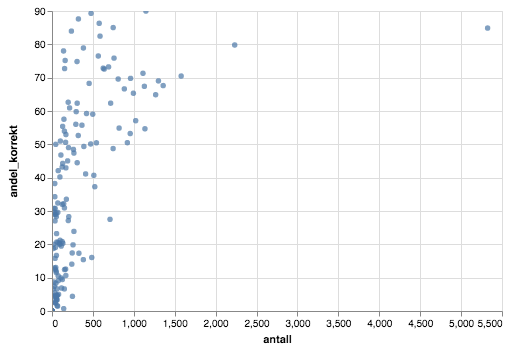

In [245]:
import pdvega
pv.vgplot.scatter(x='antall', y='andel_korrekt')

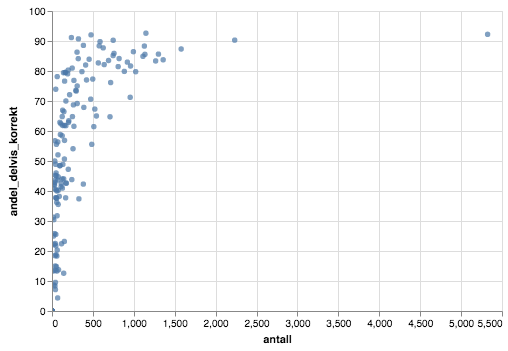

In [246]:
pv.vgplot.scatter(x='antall', y='andel_delvis_korrekt')

In [247]:
data = pd.merge(pred,nace_beskrivelse, how='left', on='nace')
data = data.rename(columns={'nace_beskrivelse':'nace_tekst'})
data.head(10)

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_tekst
0,167139,86.211,Ja,86.211,86.221,86.230,fastlegepraksis.,Allmenn legetjeneste
1,60540,90.031,Ja,90.031,90.012,85.522,produksjon av kunst og håndverk.,Selvstendig kunstnerisk virksomhet innen visue...
2,213364,68.209,Delvis,01.110,02.200,68.209,drift av jordbrukseiendom.,Utleie av egen eller leid fast eiendom ellers
3,14610,46.520,Nei,82.990,79.120,78.100,konkursbo.,Engroshandel med elektronikkutstyr og telekomm...
4,187969,71.129,Ja,71.129,85.599,78.200,utleie av personell innen offshore og onshore ...,Annen teknisk konsulentvirksomhet
5,46309,46.180,Nei,96.090,86.909,82.990,videreformidling av salgstjenester. frilans se...,Agenturhandel med spesialisert vareutvalg ellers
6,150740,75.000,Ja,75.000,93.130,86.221,veterinærvakt.,Veterinærtjenester
7,308842,47.919,Delvis,47.990,47.919,86.909,amway distributør i nettverksalg.,Postordre-/Internetthandel med annet spesialis...
8,158475,62.090,Nei,43.210,71.129,62.020,installasjon av treningssystem for brannmenn.,Andre tjenester tilknyttet informasjonsteknologi
9,471601,86.211,Nei,74.902,79.902,90.035,legegjerning.,Allmenn legetjeneste


In [248]:
data = pd.merge(data,nace_beskrivelse, how='left', left_on='pred_1', right_on='nace', suffixes=['','_pred_1'])
data = pd.merge(data,nace_beskrivelse, how='left', left_on='pred_2', right_on='nace', suffixes=['','_pred_2'])
data = pd.merge(data,nace_beskrivelse, how='left', left_on='pred_3', right_on='nace', suffixes=['','_pred_3'])

In [249]:
from IPython.display import display
display(data)

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_tekst,nace_pred_1,nace_beskrivelse,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
0,167139,86.211,Ja,86.211,86.221,86.230,fastlegepraksis.,Allmenn legetjeneste,86.211,Allmenn legetjeneste,86.221,"Spesialisert legetjeneste, unntatt psykiatrisk...",86.230,Tannhelsetjenester
1,60540,90.031,Ja,90.031,90.012,85.522,produksjon av kunst og håndverk.,Selvstendig kunstnerisk virksomhet innen visue...,90.031,Selvstendig kunstnerisk virksomhet innen visue...,90.012,Utøvende kunstnere og underholdningsvirksomhet...,85.522,Undervisning i kunstfag
2,213364,68.209,Delvis,01.110,02.200,68.209,drift av jordbrukseiendom.,Utleie av egen eller leid fast eiendom ellers,01.110,"Dyrking av korn (unntatt ris), belgvekster og ...",02.200,Avvirkning,68.209,Utleie av egen eller leid fast eiendom ellers
3,14610,46.520,Nei,82.990,79.120,78.100,konkursbo.,Engroshandel med elektronikkutstyr og telekomm...,82.990,Annen forretningsmessig tjenesteyting ikke nev...,79.120,Reisearrangørvirksomhet,78.100,Rekruttering og formidling av arbeidskraft
4,187969,71.129,Ja,71.129,85.599,78.200,utleie av personell innen offshore og onshore ...,Annen teknisk konsulentvirksomhet,71.129,Annen teknisk konsulentvirksomhet,85.599,Annen undervisning ikke nevnt annet sted,78.200,Utleie av arbeidskraft
5,46309,46.180,Nei,96.090,86.909,82.990,videreformidling av salgstjenester. frilans se...,Agenturhandel med spesialisert vareutvalg ellers,96.090,Personlig tjenesteyting ikke nevnt annet sted,86.909,Andre helsetjenester,82.990,Annen forretningsmessig tjenesteyting ikke nev...
6,150740,75.000,Ja,75.000,93.130,86.221,veterinærvakt.,Veterinærtjenester,75.000,Veterinærtjenester,93.130,Treningssentre,86.221,"Spesialisert legetjeneste, unntatt psykiatrisk..."
7,308842,47.919,Delvis,47.990,47.919,86.909,amway distributør i nettverksalg.,Postordre-/Internetthandel med annet spesialis...,47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,86.909,Andre helsetjenester
8,158475,62.090,Nei,43.210,71.129,62.020,installasjon av treningssystem for brannmenn.,Andre tjenester tilknyttet informasjonsteknologi,43.210,Elektrisk installasjonsarbeid,71.129,Annen teknisk konsulentvirksomhet,62.020,Konsulentvirksomhet tilknyttet informasjonstek...
9,471601,86.211,Nei,74.902,79.902,90.035,legegjerning.,Allmenn legetjeneste,74.902,Modellbyråvirksomhet,79.902,Guider og reiseledere,90.035,Selvstendig kunstnerisk virksomhet innen blogging


In [255]:
print(f"Antall: {len(data[data['nace']=='46.150'])}")
data[data['nace']=='46.150']

Antall: 22


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_tekst,nace_pred_1,nace_beskrivelse,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
69,146382,46.150,Nei,74.103,43.320,31.090,"agenturhandel med møbler, husholdningsmaskiner...","Agenturhandel med møbler, husholdningsvarer og...",74.103,"Interiørarkitekt, interiørdesign og interiørko...",43.320,Snekkerarbeid,31.090,Produksjon av møbler ellers
160,411186,46.150,Nei,47.990,47.919,46.180,salg utenom butikk. produksjonsinntekt for sal...,"Agenturhandel med møbler, husholdningsvarer og...",47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,46.180,Agenturhandel med spesialisert vareutvalg ellers
2040,474080,46.150,Nei,47.990,47.919,73.110,selvstendig selger av gaver og interiør. provi...,"Agenturhandel med møbler, husholdningsvarer og...",47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,73.110,Reklamebyråer
3071,296236,46.150,Nei,47.990,47.919,82.990,agenturvirksomhet på provisjonsbasis. salg av ...,"Agenturhandel med møbler, husholdningsvarer og...",47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,82.990,Annen forretningsmessig tjenesteyting ikke nev...
5620,3049,46.150,Nei,82.990,73.110,70.220,handelsagent i norge for et dansk firma som se...,"Agenturhandel med møbler, husholdningsvarer og...",82.990,Annen forretningsmessig tjenesteyting ikke nev...,73.110,Reklamebyråer,70.220,Bedriftsrådgivning og annen administrativ rådg...
8391,460633,46.150,Nei,47.990,47.919,46.180,agentur. provisjonsbasert salg av interiørarti...,"Agenturhandel med møbler, husholdningsvarer og...",47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,46.180,Agenturhandel med spesialisert vareutvalg ellers
12565,541465,46.150,Nei,94.991,79.903,93.190,"handelsagent, reiser rundt med vareprøver, pro...","Agenturhandel med møbler, husholdningsvarer og...",94.991,Aktiviteter i andre interesseorganisasjoner ik...,79.903,"Opplevelses-, arrangements- og aktivitetsarran...",93.190,Andre sportsaktiviteter
19619,193733,46.150,Nei,82.990,70.220,71.129,agenturvirksomhet vedrørende import av interiø...,"Agenturhandel med møbler, husholdningsvarer og...",82.990,Annen forretningsmessig tjenesteyting ikke nev...,70.220,Bedriftsrådgivning og annen administrativ rådg...,71.129,Annen teknisk konsulentvirksomhet
21956,387375,46.150,Nei,47.990,47.919,46.180,"agent for salg av leker, spill, tegnesaker, ko...","Agenturhandel med møbler, husholdningsvarer og...",47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,46.180,Agenturhandel med spesialisert vareutvalg ellers
24871,100263,46.150,Nei,47.990,47.919,45.112,kjøp og salg av diverse utstyr og interiør.,"Agenturhandel med møbler, husholdningsvarer og...",47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,45.112,"Detaljhandel med biler og lette motorvogner, u..."


In [260]:
print(f"Antall: {len(data[data['nace']=='41.200'])}")
data[data['nace']=='41.200']

Antall: 1579


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_tekst,nace_pred_1,nace_beskrivelse,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
11,237763,41.200,Ja,41.200,43.320,01.451,oppføring av bygninger,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,01.451,Sauehold
17,274917,41.200,Delvis,45.200,45.112,41.200,byggmester. import av motorkjøretøy.,Oppføring av bygninger,45.200,"Vedlikehold og reparasjon av motorvogner, unnt...",45.112,"Detaljhandel med biler og lette motorvogner, u...",41.200,Oppføring av bygninger
27,418115,41.200,Ja,41.200,43.320,81.101,vedlikehold av bygninger.,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,81.101,Vaktmestertjenester
37,23726,41.200,Nei,86.909,94.991,85.599,tømrar arbeid og dette som vedrører dette yrke.,Oppføring av bygninger,86.909,Andre helsetjenester,94.991,Aktiviteter i andre interesseorganisasjoner ik...,85.599,Annen undervisning ikke nevnt annet sted
106,550533,41.200,Ja,41.200,71.121,43.120,bygg og anlegg: oppføring av bygninger.,Oppføring av bygninger,41.200,Oppføring av bygninger,71.121,Byggeteknisk konsulentvirksomhet,43.120,Grunnarbeid
131,480715,41.200,Ja,41.200,71.121,43.320,prosjektering innenfor bygg og anlegg og annen...,Oppføring av bygninger,41.200,Oppføring av bygninger,71.121,Byggeteknisk konsulentvirksomhet,43.320,Snekkerarbeid
187,478771,41.200,Ja,41.200,71.121,43.120,bygg og anlegg: oppføring av bygninger.,Oppføring av bygninger,41.200,Oppføring av bygninger,71.121,Byggeteknisk konsulentvirksomhet,43.120,Grunnarbeid
295,547874,41.200,Ja,41.200,43.320,43.990,"entreprenørvirksomhet, bygging og rehabiliteri...",Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,43.990,Annen spesialisert bygge- og anleggsvirksomhet
326,334647,41.200,Ja,41.200,43.320,43.990,"oppføring av bygninger, restaurering og rehabi...",Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,43.990,Annen spesialisert bygge- og anleggsvirksomhet
332,253195,41.200,Ja,41.200,43.320,01.451,oppføring av bygninger,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,01.451,Sauehold


In [256]:
print(f"Antall: {len(data[data['nace']=='94.991'])}")
data[data['nace']=='94.991']

Antall: 5324


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst,nace_tekst,nace_pred_1,nace_beskrivelse,nace_pred_2,nace_beskrivelse_pred_2,nace_pred_3,nace_beskrivelse_pred_3
19,550492,94.991,Nei,79.902,79.903,93.291,hageaktiviteter teoretiske og praktiske.,Aktiviteter i andre interesseorganisasjoner ik...,79.902,Guider og reiseledere,79.903,"Opplevelses-, arrangements- og aktivitetsarran...",93.291,Opplevelsesaktiviteter
40,452,94.991,Ja,94.991,68.320,88.995,velforening.,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,88.995,Sosiale velferdsorganisasjoner
51,101306,94.991,Ja,94.991,93.120,85.599,fadder finnmark er organisasjonen for fadderuk...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,85.599,Annen undervisning ikke nevnt annet sted
52,402971,94.991,Ja,94.991,88.995,94.120,fremme kunnskap om og interesse for urininkont...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,88.995,Sosiale velferdsorganisasjoner,94.120,Yrkessammenslutninger
61,453086,94.991,Ja,94.991,93.120,90.012,turmarsjforening som arrangerer marsjer gjenno...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,90.012,Utøvende kunstnere og underholdningsvirksomhet...
62,462205,94.991,Nei,93.120,85.510,93.190,idrettslag.,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,85.510,Undervisning innen idrett og rekreasjon,93.190,Andre sportsaktiviteter
65,542456,94.991,Ja,94.991,93.120,94.200,fremme kitemiljø i svelvik.,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,94.200,Arbeidstakerorganisasjoner
80,139183,94.991,Ja,94.991,88.995,94.120,sosiale aktiviteter i canal digital norge.,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,88.995,Sosiale velferdsorganisasjoner,94.120,Yrkessammenslutninger
86,45471,94.991,Ja,94.991,88.995,94.120,fotoforening. sosialt og faglig miljø for foto...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,88.995,Sosiale velferdsorganisasjoner,94.120,Yrkessammenslutninger
102,200959,94.991,Ja,94.991,94.110,94.120,temakafe for kreftrammede i vesterålen.,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.110,Næringslivs- og arbeidsgiverorganisasjoner,94.120,Yrkessammenslutninger


In [257]:
writer = pd.ExcelWriter('./data/prediksjon.xlsx')
data.to_excel(writer,'prediksjon')
writer.save()